# News Article Similarity Analysis

In [36]:
import urllib.request
import os
import zipfile
import nltk
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Data

In [3]:
# download the dataset
!wget https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv

--2025-04-05 09:29:29--  https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18236066 (17M) [text/plain]
Saving to: ‘news_articles.csv.1’

news_articles.csv.1 100%[===================>]  17.39M  76.4MB/s    in 0.2s    

2025-04-05 09:29:30 (76.4 MB/s) - ‘news_articles.csv.1’ saved [18236066/18236066]



In [ ]:
# Load dataset
df = pd.read_csv('news_articles.csv')

# Display the first few rows of the dataset
df.head()

,topic,headline,author,link,description,published date
0,entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
1,entertainment,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
2,entertainment,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
3,entertainment,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
4,entertainment,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26


## Exploratory data analysis (EDA)

In [5]:
# Display basic dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55335 entries, 0 to 55334
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   topic           55335 non-null  object
 1   headline        55334 non-null  object
 2   author          45881 non-null  object
 3   link            55335 non-null  object
 4   description     49630 non-null  object
 5   published date  55335 non-null  object
dtypes: object(6)
memory usage: 2.5+ MB


In [ ]:
# Check for missing values
df.isna().sum()

,0
topic,0
headline,1
author,9454
link,0
description,5705
published date,0


In [7]:
# How long is the longest description?
length_description = df['description'].str.len()
print(f'Longest description: {length_description.max()}')

# How long is the shortest description?
print(f'Shortest description: {length_description.min()}')

Longest description: 1094.0
Shortest description: 1.0


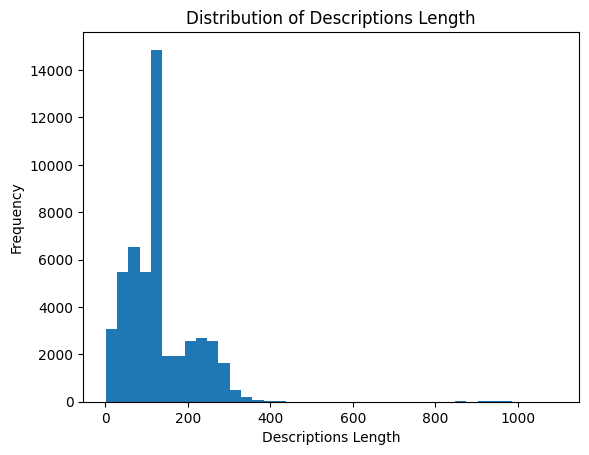

In [8]:
# Plot the Distribution of description Length
plt.hist(length_description, bins=40)
plt.title('Distribution of Descriptions Length')
plt.xlabel('Descriptions Length')
plt.ylabel('Frequency')

plt.show()

## Text Preprocessing

In [ ]:
# Remove rows with missing values
df.dropna(inplace=True)

In [ ]:
# Stop words
stop_words = set(stopwords.words('english'))

# Preprocess the text data
def preprocessing(text):
  '''
  Lowercase the text,
  tokenize it,
  remove stop words and non-alphabetic tokens.
  '''
  text = text.lower()
  text_tokens = word_tokenize(text)
  clean_tokens = [token for token in text_tokens if token.isalpha() and token not in stop_words]
  return clean_tokens

In [ ]:
# Apply the preprocessing function to the description column
df['clean_tokens']=df['description'].apply(preprocessing)

# Display the first few rows of the cleaned tokens
df['clean_tokens'].head()

,clean_tokens
0,"[course, song]"
1,"[actor, longtime, girlfriend, anna, eberstein,..."
2,"[right, equate, horrific, incidents, sexual, a..."
3,"[great, joining, week]"
4,"[myer, kids, may, pushing, new, powers, film, ..."


## GloVe-Based Embeddings

In [ ]:
# Download GloVe embeddings
url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')

urllib.request.urlretrieve(url, output)

# Unzip the file
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')

In [13]:
# Load GloVe Embeddings
glove_path = "glove/glove.6B.100d.txt"

# Read the file and store embeddings
embeddings_dict = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_dict[word] = vector

In [ ]:
# Tokens to GloVe vector
def tokens_to_glove_vector(tokens, glove=embeddings_dict, dim=100):
    vectors = [glove[token] for token in tokens if token in glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [ ]:
# Apply the function to the clean tokens
df['glove_vector'] = df['clean_tokens'].apply(tokens_to_glove_vector)

In [ ]:
# Display the first few rows of the DataFrame with GloVe vectors
df[['clean_tokens', 'glove_vector']].head()

,clean_tokens,glove_vector
0,"[course, song]","[-0.142866, 0.002452001, 0.57652, 0.047114998,..."
1,"[actor, longtime, girlfriend, anna, eberstein,...","[0.06428084, -0.20556878, -0.010586997, -0.065..."
2,"[right, equate, horrific, incidents, sexual, a...","[0.054433, -0.011417464, 0.19488525, -0.232795..."
3,"[great, joining, week]","[0.062111337, 0.17907566, 0.30704334, -0.17383..."
4,"[myer, kids, may, pushing, new, powers, film, ...","[0.17911863, -8.2377344e-05, 0.278032, -0.2348..."


## PCA for Dimensionality Reduction

In [ ]:
# Stack all glove_vectors vertically to create a 2D numpy array
X = np.vstack(df['glove_vector'].values)

#Apply PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Store in DataFrame
df['pca_x'] = X_reduced[:, 0]
df['pca_y'] = X_reduced[:, 1]

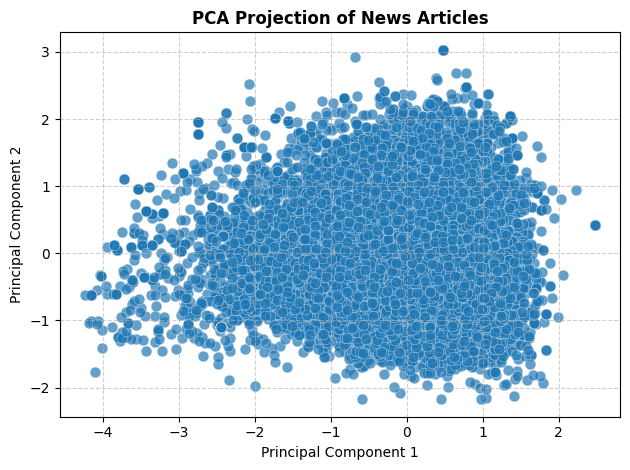

In [ ]:
# Plot the PCA results
plt.scatter(df['pca_x'],
            df['pca_y'],
            alpha=0.7,
            edgecolor='w',
            linewidth=0.3,
            s=60)

plt.title('PCA Projection of News Articles', weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

## K-Means Clustering

In [ ]:
# Determine the optimal number of clusters using Elbow Method
X = df[['pca_x', 'pca_y']].values

wcss = []  # within-cluster sum of squares
K = range(1, 11)

# Loop through the range of K values and fit KMeans
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

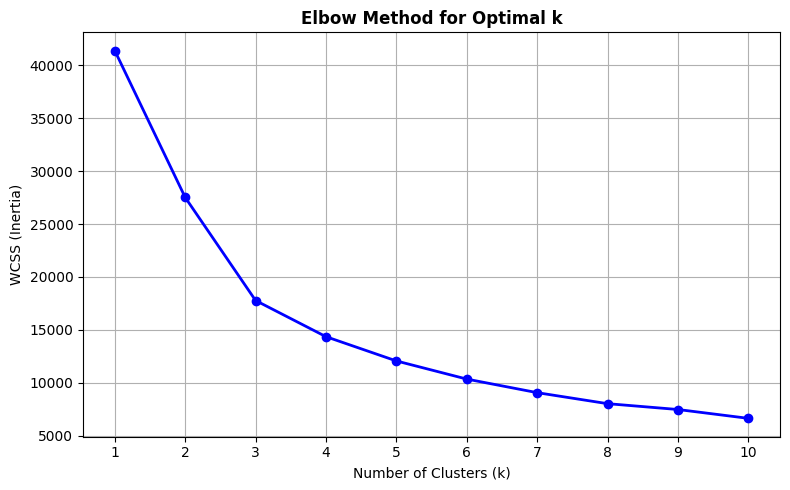

In [31]:
# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-', linewidth=2, markersize=6)

plt.title('Elbow Method for Optimal k', weight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')

plt.grid(True)
plt.xticks(K)
plt.tight_layout()

plt.show()

In [ ]:
# Apply KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')

# Fit the model and predict the clusters
df['cluster'] = kmeans.fit_predict(X)

In [34]:
df[['description', 'cluster']].head()

,description,cluster
0,Of course it has a song.,0
1,The actor and his longtime girlfriend Anna Ebe...,2
2,"""It is not right to equate horrific incidents ...",2
3,There's a great mini-series joining this week.,1
4,"Myer's kids may be pushing for a new ""Powers"" ...",0


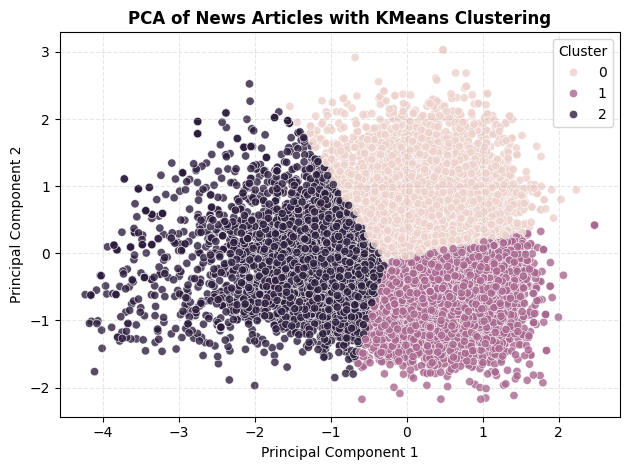

In [ ]:
# Scatter plot with clusters colored
sns.scatterplot(data=df,
                x='pca_x',
                y='pca_y',
                hue='cluster',
                alpha=0.8)

# Titles and labels
plt.title('PCA of News Articles with KMeans Clustering', weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Display the grid, legend, and layout
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Cluster', loc='best')
plt.tight_layout()

plt.savefig('pca_kmeans.png')

plt.show()

## Visualizing Clusters with Word Clouds

In [ ]:
# Generate word clouds for each cluster
def generate_word_cloud(cluster_data, remove_words=None):
    """
    Generates a word cloud for a given set of text data (cluster).
    """
    # Combine all the text from the cluster
    text = " ".join(cluster_data)

    # Set up custom stopwords
    stopwords = set(WordCloud().stopwords)  # Get default stopwords
    if remove_words:
        stopwords.update(remove_words)  # Add your custom words to stopwords

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400,background_color='white', stopwords=stopwords).generate(text)

    # Plot the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for Cluster {cluster_id}')

    plt.savefig(f'word_cloud_cluster_{cluster_id}.png')
    plt.show()

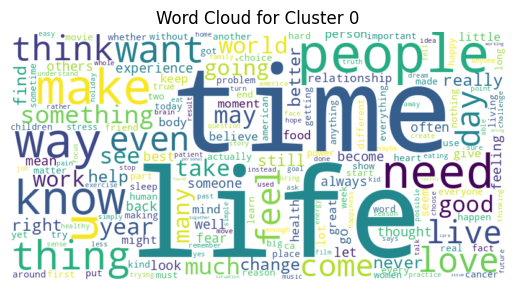

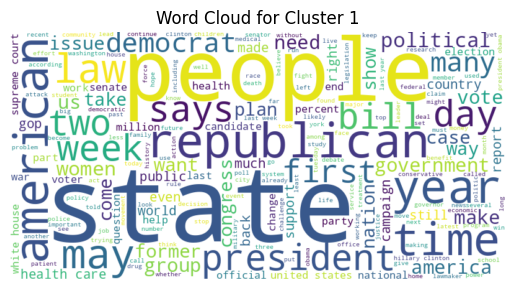

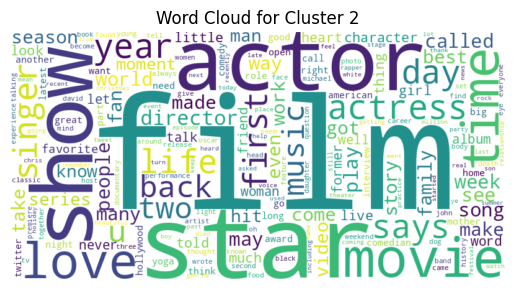

In [ ]:
# These are common words that may not add value to the word cloud
remove_words = ["said", "say", "new", "one", "like"]

# Loop over the clusters and generate a word cloud for each
for cluster_id in range(3):
    cluster_tokens = df[df['cluster'] == cluster_id]['clean_tokens'].values
    # Flatten the list of token lists into a single list
    flattened_tokens = [token for sublist in cluster_tokens for token in sublist]

    # Join the flattened tokens into a single string
    cluster_text = " ".join(flattened_tokens)

    # Generate word cloud for this cluster
    generate_word_cloud([cluster_text], remove_words=remove_words)